## Ridge Regression

In this notebook, we will run ridge regression multiple times with different L2 penalties to see which one produces the best fit. We will revisit the example of polynomial regression as a means to see the effect of L2 regularization. In particular, we will:
Use a pre-built implementation of regression (GraphLab Create) to run polynomial regression
Use matplotlib to visualize polynomial regressions
Use a pre-built implementation of regression (GraphLab Create) to run polynomial regression, this time with L2 penalty
Use matplotlib to visualize polynomial regressions under L2 regularization
Choose best L2 penalty using cross-validation.
Assess the final fit using test data.
We will continue to use the House data from previous notebooks. (In the next programming assignment for this module, you will implement your own ridge regression learning algorithm using gradient descent.)


### Polynomial regression, revisited

In [165]:
import pandas as pd
import numpy as np

In [166]:
def polynomial_sframe(feature, degree):
    poly_dataframe = pd.DataFrame()
    poly_dataframe['power_1'] = feature
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        for power in range(2, degree+1):
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # assign poly_dataframe[name] to be feature^power; use apply(*)
            poly_dataframe[name] = feature.apply(lambda x: x**power)
        
    return poly_dataframe

Let's use matplotlib to visualize what a polynomial regression looks like on the house data.

In [167]:
import matplotlib.pyplot as plt
%matplotlib inline

In [168]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':str, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

In [169]:
sales = pd.read_csv("kc_house_data.csv", dtype=dtype_dict)

We will use the sqft_living variable. For plotting purposes (connecting the dots), you'll need to sort by the values of sqft_living. For houses with identical square footage, we break the tie by their prices.

In [6]:
sales = sales.sort_values(["sqft_living", "price"])

Let us revisit the 15th-order polynomial model using the 'sqft_living' input. Generate polynomial features up to degree 15 using polynomial_sframe() and fit a model with these features. When fitting the model, use an L2 penalty of 1e-5:

In [7]:
l2_small_penalty = 1e-5

In [8]:
poly1_data = polynomial_sframe(sales["sqft_living"], 15)
my_feature = poly1_data.columns

In [9]:
from sklearn import linear_model
from sklearn.linear_model import Ridge
poly1_data["price"] = sales["price"]

In [10]:
rig1 = Ridge(alpha=l2_small_penalty, normalize=True)
rig1.fit(poly1_data[my_feature], poly1_data["price"])

Ridge(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [11]:
print (rig1.coef_)

[  1.74425503e+02  -7.83644074e-02   3.73280427e-05  -2.85554311e-09
  -2.37487557e-13   9.70529709e-18   1.77791834e-21   9.76993158e-26
   7.78897288e-31  -3.83833667e-34  -4.52940095e-38  -3.16694117e-42
  -1.24102475e-46   4.53456467e-51   1.63425896e-54]


### Ridge Regression (gradient descent)

In [170]:
def get_numpy_data(data, features, output):
    data['constant'] = 1 # add a constant column to a dataframe
    # prepend variable 'constant' to the features list
    features = ['constant'] + features
    # select the columns of dataframe given by the ‘features’ list into the SFrame ‘features_sframe’

    # this will convert the features_sframe into a numpy matrix with GraphLab Create >= 1.7!!
    features_matrix = data[features].as_matrix(columns=None)
    # assign the column of data_sframe associated with the target to the variable ‘output_sarray’

    # this will convert the SArray into a numpy array:
    output_array = data[output].as_matrix(columns=None) # GraphLab Create>= 1.7!!
    return(features_matrix, output_array)

In [171]:
def predict_output(feature_matrix, weights):
    predictions = None
    predictions = np.dot(feature_matrix, weights)
    return (predictions)

### Computing the Derivative


We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part.  As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [172]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    derivative = None
    if feature_is_constant is True:
        derivative = 2 * (errors * feature).sum()
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative = 2 * (errors * feature).sum() + 2*l2_penalty*weight
    return derivative

In [173]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False))
print (np.sum(errors*example_features[:,1])*2+20.)
print ('')

# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True))
print (np.sum(errors)*2.)

-5.6554166816e+13
-5.6554166816e+13

-22446749330.0
-22446749330.0


### Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [174]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights) # make sure it's a numpy array
    for iter in range(0, max_iterations):
    #while not reached maximum number of iterations:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        prediction = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = prediction - output
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i == 0:
                is_constant = True
            else:
                is_constant = False
            derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, is_constant)
            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i] - derivative * step_size
    return weights

### Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [175]:
simple_features = ["sqft_living"]
my_output = 'price'

Let us split the dataset into training set nd test set. Make sure to use seed = 0.

In [176]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(sales, train_size=0.8, random_state=0)

In [177]:
pd.options.mode.chained_assignment = None

In [178]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features,my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

In [179]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_0_penalty`

we'll use them later.

In [180]:
l2_penalty = 0.
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix,
                                                             output,
                                                             initial_weights,
                                                             step_size,
                                                             l2_penalty,
                                                             max_iterations)

In [181]:
print (simple_weights_0_penalty)

[ -1.68107747e-01   2.64595376e+02]


Next, let's consider high regularization. Set the l2_penalty to 1e11 and run your ridge regression algorithm to learn the weights of your model. Call your weights:
simple_weights_high_penalty
we'll use them later.

In [182]:
l2_penalty = 1e11
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix,
                                                               output,
                                                               initial_weights,
                                                              step_size,
                                                              l2_penalty,
                                                              max_iterations)

In [183]:
print (simple_weights_high_penalty)

[   9.79155301  125.07002033]


This code will plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

In [184]:
import matplotlib.pyplot as plt
%matplotlib inline

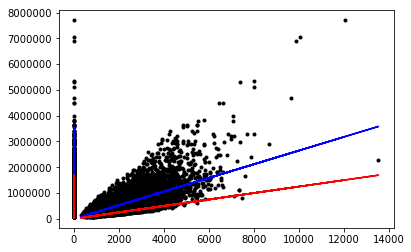

In [185]:
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [186]:
test_data["price_1"] = predict_output(simple_test_feature_matrix, initial_weights)
test_data['price_2'] = predict_output(simple_test_feature_matrix, simple_weights_0_penalty)
test_data['price_3'] = predict_output(simple_test_feature_matrix, simple_weights_high_penalty)

In [187]:
print(test_data[['id','sqft_living','price','price_1','price_2','price_3']].head())

               id  sqft_living      price  price_1       price_2  \
17384  1453602313       1430.0   297000.0      0.0  3.783712e+05   
722    2225059214       4670.0  1578000.0      0.0  1.235660e+06   
2680   2768000270       1440.0   562100.0      0.0  3.810172e+05   
18754  6819100040       1130.0   631500.0      0.0  2.989926e+05   
14554  4027700666       3180.0   780000.0      0.0  8.414131e+05   

             price_3  
17384  178859.920629  
722    584086.786507  
2680   180110.620832  
18754  141338.914529  
14554  397732.456211  


In [188]:
def get_residual_sum_of_squares2(outcome, prediction):
    RSS = None
    error = outcome - prediction
    error_sq = error **2
    RSS = error_sq.sum()
    return(RSS)

print ("[simple regresion]")
print ("RSS OF INITIAL WEIGHTS:             %f" %get_residual_sum_of_squares2(test_data['price'], test_data['price_1']))
print ("RSS OF simple_weights_0_penalty:    %f" %get_residual_sum_of_squares2(test_data['price'], test_data['price_2']))
print ("RSS OF simple_weights_high_penalty: %f" %get_residual_sum_of_squares2(test_data['price'], test_data['price_3']))

[simple regresion]
RSS OF INITIAL WEIGHTS:             1724972157778353.000000
RSS OF simple_weights_0_penalty:    267785724039172.343750
RSS OF simple_weights_high_penalty: 650754968300805.750000


### Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of your training and test data with these two features. 

In [189]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

In [190]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

In [191]:
l2_penalty = 0.
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix,
                                                               output,
                                                               initial_weights,
                                                               step_size,
                                                               l2_penalty,
                                                               max_iterations)
print("multiple_weights_0_penalty = %s" % str(multiple_weights_0_penalty))

l2_penalty = 1e11
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix,
                                                                  output,
                                                                  initial_weights,
                                                                  step_size,
                                                                  l2_penalty,
                                                                  max_iterations)
print("multiple_weights_high_penalty = %s" % str(multiple_weights_high_penalty))

test_data['price_1'] = predict_output(test_feature_matrix, initial_weights)
test_data['price_2'] = predict_output(test_feature_matrix, multiple_weights_0_penalty)
test_data['price_3'] = predict_output(test_feature_matrix, multiple_weights_high_penalty)

print(test_data[['id','sqft_living','sqft_living15','price','price_1','price_2','price_3']].head())

print ('[multiple regression]')
print ("RSS of initial weights:               %f" % get_residual_sum_of_squares2(test_data['price'], test_data['price_1']))
print ("RSS of multiple_weights_0_penalty:    %f" % get_residual_sum_of_squares2(test_data['price'], test_data['price_2']))
print ("RSS of multiple_weights_high_penalty: %f" % get_residual_sum_of_squares2(test_data['price'], test_data['price_3']))

multiple_weights_0_penalty = [  -0.36105686  245.10302972   21.88723514]
multiple_weights_high_penalty = [  6.76344892  91.93393155  78.75003429]
               id  sqft_living  sqft_living15      price  price_1  \
17384  1453602313       1430.0         1430.0   297000.0      0.0   
722    2225059214       4670.0         4230.0  1578000.0      0.0   
2680   2768000270       1440.0         1440.0   562100.0      0.0   
18754  6819100040       1130.0         1680.0   631500.0      0.0   
14554  4027700666       3180.0         2440.0   780000.0      0.0   

            price_2        price_3  
17384  3.817957e+05  244084.834598  
722    1.237214e+06  762450.868827  
2680   3.844656e+05  245791.674256  
18754  3.137366e+05  236192.163705  
14554  8.328321e+05  484506.749441  
[multiple regression]
RSS of initial weights:               1724972157778353.000000
RSS of multiple_weights_0_penalty:    266037590365260.843750
RSS of multiple_weights_high_penalty: 462809239744846.250000


## Lasso Regression

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

In [192]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import Lasso
from math import log, sqrt

In [193]:
sales["sqft_living_sqrt"] = sales["sqft_living"].apply(sqrt)
sales["sqft_lot_sqrt"] = sales["sqft_lot"].apply(sqrt)
sales["bedrooms_square"] = sales["bedrooms"] * sales["bedrooms"]
sales["floors"] = sales["floors"].astype(float)
sales["floors_square"] = sales["floors"]*sales["floors"]

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

### Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [194]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [195]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

In [196]:

model_all = linear_model.Lasso(alpha=5e2, normalize=True) # set parameters
model_all.fit(sales[all_features], sales['price']) # learn weights

Lasso(alpha=500.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [197]:
pd.Series(model_all.coef_,index=all_features)

bedrooms                0.000000
bedrooms_square         0.000000
bathrooms               0.000000
sqft_living           134.439314
sqft_living_sqrt        0.000000
sqft_lot                0.000000
sqft_lot_sqrt           0.000000
floors                  0.000000
floors_square           0.000000
waterfront              0.000000
view                24750.004586
condition               0.000000
grade               61749.103091
sqft_above              0.000000
sqft_basement           0.000000
yr_built               -0.000000
yr_renovated            0.000000
dtype: float64

In [198]:
testing = pd.read_csv('wk3_kc_house_test_data.csv', dtype=dtype_dict)
training = pd.read_csv('wk3_kc_house_train_data.csv', dtype=dtype_dict)
validation = pd.read_csv('wk3_kc_house_valid_data.csv', dtype=dtype_dict)

In [199]:
testing['sqft_living_sqrt'] = testing['sqft_living'].apply(sqrt)
testing['sqft_lot_sqrt'] = testing['sqft_lot'].apply(sqrt)
testing['bedrooms_square'] = testing['bedrooms']*testing['bedrooms']
testing["floors"] = testing["floors"].astype(float)
testing['floors_square'] = testing['floors']*testing['floors']

training['sqft_living_sqrt'] = training['sqft_living'].apply(sqrt)
training['sqft_lot_sqrt'] = training['sqft_lot'].apply(sqrt)
training['bedrooms_square'] = training['bedrooms']*training['bedrooms']
training["floors"] = training["floors"].astype(float)
training['floors_square'] = training['floors']*training['floors']

validation['sqft_living_sqrt'] = validation['sqft_living'].apply(sqrt)
validation['sqft_lot_sqrt'] = validation['sqft_lot'].apply(sqrt)
validation['bedrooms_square'] = validation['bedrooms']*validation['bedrooms']
validation["floors"] = validation["floors"].astype(float)
validation['floors_square'] = validation['floors']*validation['floors']


In [200]:
l1_penalty = np.logspace(1, 7, num=13)
l1_penalty

array([  1.00000000e+01,   3.16227766e+01,   1.00000000e+02,
         3.16227766e+02,   1.00000000e+03,   3.16227766e+03,
         1.00000000e+04,   3.16227766e+04,   1.00000000e+05,
         3.16227766e+05,   1.00000000e+06,   3.16227766e+06,
         1.00000000e+07])


Learn a model on TRAINING data using the specified l1_penalty. Make sure to specify normalize=True in the constructor:
Compute the RSS on VALIDATION for the current model (print or save the RSS)

In [201]:
for i in l1_penalty:
    train_model_all = linear_model.Lasso(i, normalize=True)
    train_model_all.fit(training[all_features],training["price"])
    y = pd.Series(train_model_all.coef_, index=all_features)
    RSS = np.sum((train_model_all.predict(validation[all_features]) - validation["price"]))**2
    print (i, RSS)

10.0 2.58285854971e+14
31.6227766017 1.71523626375e+14
100.0 7.32661239062e+13
316.227766017 1.02582936949e+12
1000.0 7.91973448461e+14
3162.27766017 2.31682208663e+15
10000.0 2.31682208663e+15
31622.7766017 2.31682208663e+15
100000.0 2.31682208663e+15
316227.766017 2.31682208663e+15
1000000.0 2.31682208663e+15
3162277.66017 2.31682208663e+15
10000000.0 2.31682208663e+15


Now that you have selected an L1 penalty, compute the RSS on TEST data for the model with the best L1 penalty.


In [202]:
train2_model_all = linear_model.Lasso(alpha=10.0, normalize=True)

In [203]:
train2_model_all.fit(training[all_features], training['price'])

Lasso(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [204]:
np.count_nonzero(train2_model_all.coef_) + np.count_nonzero(train2_model_all.intercept_)

15

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.
You are going to implement a simple, two phase procedure to achieve this goal:
Explore a large range of ‘l1_penalty’ values to find a narrow region of ‘l1_penalty’ values where models are likely to have the desired number of non-zero weights. Further explore the narrow region you found to find a good value for ‘l1_penalty’ that achieves the desired sparsity. Here, we will again use a validation set to choose the best value for ‘l1_penalty’.

Assign 7 to the variable ‘max_nonzeros’.

Exploring large range of l1_penalty

For l1_penalty in np.logspace(1, 4, num=20):


In [205]:
max_feature = 7

In [206]:
alpha = np.logspace(1,4,num=20)
alpha

array([    10.        ,     14.38449888,     20.69138081,     29.76351442,
           42.81332399,     61.58482111,     88.58667904,    127.42749857,
          183.29807108,    263.66508987,    379.26901907,    545.55947812,
          784.75997035,   1128.83789168,   1623.77673919,   2335.72146909,
         3359.81828628,   4832.93023857,   6951.92796178,  10000.        ])

In [207]:
counts_of_nonzeros = []
for l1_penalty in alpha:
    train_model_2 = linear_model.Lasso(l1_penalty, normalize=True) # set parameters
    train_model_2.fit(training[all_features], training['price']) # learn weights
    if train_model_2.intercept_ != 0:
        counts = np.count_nonzero(train_model_2.coef_) + np.count_nonzero(train_model_2.intercept_)
        counts_of_nonzeros.append((l1_penalty,counts))
    elif train_model_2.intercept_==0:
        counts = np.count_nonzero(train_model_2.coef_) + 1
        counts_of_nonzeros.append((l1_penalty,counts))

In [208]:
print (counts_of_nonzeros)

[(10.0, 15), (14.384498882876629, 15), (20.691380811147901, 15), (29.763514416313178, 15), (42.813323987193932, 13), (61.584821106602639, 12), (88.586679041008225, 11), (127.42749857031335, 10), (183.29807108324357, 7), (263.66508987303581, 6), (379.26901907322497, 6), (545.55947811685144, 6), (784.75997035146065, 5), (1128.8378916846884, 3), (1623.776739188721, 3), (2335.7214690901214, 2), (3359.8182862837812, 1), (4832.9302385717519, 1), (6951.9279617756056, 1), (10000.0, 1)]


In [209]:
list_greater = [k for k,v in counts_of_nonzeros if v > 7]

In [210]:
l1_penalty_min = max(list_greater)

In [211]:
list_less = [m for m,n in counts_of_nonzeros if n < 7]
l1_penalty_max = min(list_less)
l1_penalty_max

263.66508987303581

In [212]:
counts_of_nonzeros_2 = []
RSS_list = []
for l1_penalty in np.linspace(l1_penalty_min,l1_penalty_max,20):
    train_model_3 = linear_model.Lasso(l1_penalty, normalize=True) # set parameters
    train_model_3.fit(training[all_features], training['price']) # learn weights
    RSS = np.sum((train_model_3.predict(validation[all_features])-validation['price'])**2)
    RSS_list.append((l1_penalty,RSS))
    if train_model_3.intercept_ != 0:
        counts = np.count_nonzero(train_model_3.coef_) + np.count_nonzero(train_model_3.intercept_)
        counts_of_nonzeros_2.append((l1_penalty,counts))
    elif train_model_3.intercept_==0:
        counts = np.count_nonzero(train_model_3.coef_) + 1
        counts_of_nonzeros_2.append((l1_penalty,counts))

In [213]:
max_7_list = [j for j,p in counts_of_nonzeros_2 if p == 7] 
max_7_list

[156.10909673930755,
 163.27949628155611,
 170.44989582380464,
 177.6202953660532,
 184.79069490830176,
 191.96109445055032,
 199.13149399279888]

In [214]:
RSS_list_2 = [(y,x) for x,y in RSS_list if x in max_7_list]

In [215]:
RSS_list_2.sort()

In [216]:
RSS_list_2

[(440037365263316.56, 156.10909673930755),
 (440777489641605.25, 163.27949628155611),
 (441566698090139.88, 170.44989582380464),
 (442406413188666.25, 177.6202953660532),
 (443296716874315.06, 184.79069490830176),
 (444239780526141.62, 191.96109445055032),
 (445230739842614.19, 199.13149399279888)]

In [217]:
train_model_4 = linear_model.Lasso(max_7_list[0], normalize=True) # set parameters
train_model_4.fit(training[all_features], training['price']) # learn weights

Lasso(alpha=156.10909673930755, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=True, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [218]:
pd.Series(train_model_4.coef_, index = all_features)

bedrooms                -0.000000
bedrooms_square         -0.000000
bathrooms            10610.890284
sqft_living            163.380252
sqft_living_sqrt         0.000000
sqft_lot                -0.000000
sqft_lot_sqrt           -0.000000
floors                   0.000000
floors_square            0.000000
waterfront          506451.687115
view                 41960.043555
condition                0.000000
grade               116253.553700
sqft_above               0.000000
sqft_basement            0.000000
yr_built             -2612.234880
yr_renovated             0.000000
dtype: float64

### Lasso Regression ( coordinate descent )

### Normalize features¶


In [223]:
import numpy as np

In [232]:
def normalize_features(features):
    norms = np.sqrt(np.sum(features**2,axis=0))
    normlized_features = features/norms
    return (normlized_features, norms)

In [233]:
features, norms = normalize_features(np.array([[3.,6.,9.],[4.,8.,12.]]))
print (features)
# should print
# [[ 0.6  0.6  0.6]
#  [ 0.8  0.8  0.8]]
print (norms)
# should print
# [5.  10.  15.]

[[ 0.6  0.6  0.6]
 [ 0.8  0.8  0.8]]
[  5.  10.  15.]


In [240]:
features = ["sqft_living","bedrooms"]
output = "price"

In [241]:
feature_matrix, output_array = get_numpy_data(sales, features, output)

In [242]:
simple_feature_matrix, norms = normalize_features(feature_matrix)
simple_feature_matrix, norms

(array([[ 0.00680209,  0.00353021,  0.00583571],
        [ 0.00680209,  0.00768869,  0.00583571],
        [ 0.00680209,  0.00230361,  0.00389048],
        ..., 
        [ 0.00680209,  0.00305154,  0.00389048],
        [ 0.00680209,  0.00478673,  0.00583571],
        [ 0.00680209,  0.00305154,  0.00389048]]),
 array([  1.47013605e+02,   3.34257264e+05,   5.14075870e+02]))

In [243]:
weights = [1,4,1]
prediction = predict_output(simple_feature_matrix, weights)

In [246]:
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1/(1+np.exp(-score))
    
    # return predictions
    return predictions

In [247]:
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)
        # Return the derivative
    return derivative

In [248]:
def compute_log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores)))
    return lp

### Taking gradient steps

In [250]:
from math import sqrt
def logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_1,w) using your predict_probability() function
        # YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)

        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)

        # Compute the errors as indicator - predictions
        errors = indicator - predictions

        for j in xrange(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # compute the derivative for coefficients[j]. Save it in a variable called derivative
            # YOUR CODE HERE
            derivative = np.dot(errors, feature_matrix[:,j])

            # add the step size times the derivative to the current coefficient
            # YOUR CODE HERE
            coefficients[j] = step_size * derivative

        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood(feature_matrix, sentiment, coefficients)
            print ('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

### Predict sentiments

In [ ]:
scores_new = np.dot(feature_matrix, variable_coefficients)

In [ ]:
predicted_sentiment = np.array([+1 if s > 0 else -1 for s in scores_new])

In [ ]:
sum(predicted_sentiment == +1)

### Measuring accuracy¶


In [ ]:
float(sum(predicted_sentiment == sentiment))/len(sentiment)